# Деревья решений решают проблемы
__Суммарное количество баллов: 10__

Вы уже знакомы с классификацией методом KNN. В этом задании предстоит реализовать другой метод классификации - дерево решений. 

Одной из его особенностей является возможность объяснить в человекочитаемой форме, почему мы отнесли объект к определенному классу. Эта особенность позволяет использовать деревья решений для создания систем, которые могут подсказывать специалистам, на что именно стоит обратить внимание при принятии решений.

In [523]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import matplotlib
from sklearn.neighbors import KDTree

### Задание 1 (1 балл)
Во время построения дерева решений нам потребуется определить, какой из предикатов лучше всего разбивает обучающую выборку. Есть два критерия, которые позволяют это сделать: критерий Джини и энтропийный критерий. Первый для подсчета информативности разбиения использует коэффициент Джини, второй - энтропию. Реализуйте подсчет этих коэффициентов, а так же подсчет информативности разбиения. 

#### Описание функций
`gini(x)` считает коэффициент Джини для массива меток

`entropy(x)` считает энтропию для массива меток

`gain(left_y, right_y, criterion)` считает информативность разбиения массива меток на левую `left_y` и правую `right_y` части при помощи `criterion`, который задается функцией (не строкой).

In [76]:
def gini(x):
    p = np.bincount(x) / x.shape[0]
    g = np.sum(p * (1 - p))
    return g
    
def entropy(x):
    freq = np.bincount(x)
    freq = freq[freq != 0]
    p = freq / x.shape[0]
    e = -np.sum(p * np.log2(p))
    return e

def gain(left_y, right_y, criterion):
    total = np.concatenate([left_y, right_y])
    tc = criterion(total)
    lc = (left_y.shape[0] / total.shape[0]) * criterion(left_y)
    rc = (right_y.shape[0] / total.shape[0]) * criterion(right_y)
    ig = tc - lc - rc
    return ig

### Задание 2 (1 балл)
Деревья решений имеют хорошую интерпретируемость, т.к. позволяют не только предсказать класс, но и объяснить, почему мы предсказали именно его. Например, мы можем его нарисовать. Чтобы сделать это, нам необходимо знать, как оно устроено внутри. Реализуйте классы, которые будут задавать структуру дерева. 

#### DecisionTreeLeaf
Поля:
1. `y` должно содержать класс, который встречается чаще всего среди элементов листа дерева

#### DecisionTreeNode
В данной домашней работе мы ограничемся порядковыми и количественными признаками, поэтому достаточно хранить измерение и значение признака, по которому разбиваем обучающую выборку.

Поля:
1. `split_dim` измерение, по которому разбиваем выборку
2. `split_value` значение, по которому разбираем выборку
3. `left` поддерево, отвечающее за случай `x[split_dim] < split_value`. Может быть `DecisionTreeNode` или `DecisionTreeLeaf`
4. `right` поддерево, отвечающее за случай `x[split_dim] >= split_value`. Может быть `DecisionTreeNode` или `DecisionTreeLeaf`

__Интерфейс классов можно и нужно менять при необходимости__ (например, для вычисления вероятности в следующем задании)

In [513]:
class DecisionTreeLeaf:
    def __init__(self, y):
        freq = np.bincount(y)
        self.y = np.argmax(freq)
        probs = freq / y.shape[0]
        self.class_probs = {i: p for i, p in enumerate(probs)}

class DecisionTreeNode:
    def __init__(self, split_dim, split_value, left, right):
        self.split_dim = split_dim
        self.split_value = split_value
        self.left = left
        self.right = right

### Задание 3 (6 баллов)
Теперь перейдем к самому дереву решений. Реализуйте класс `DecisionTreeClassifier`.

#### Описание методов
`fit(X, y)` строит дерево решений по обучающей выборке.

`predict_proba(X)` для каждого элемента из `X` возвращает словарь `dict`, состоящий из пар `(класс, вероятность)`. Вероятности классов в листе можно определить через количество объектов соответствующего класса в листе. 

#### Описание параметров конструктора
`criterion="gini"` - задает критерий, который будет использоваться при построении дерева. Возможные значения: `"gini"`, `"entropy"`.

`max_depth=None` - ограничение глубины дерева. Если `None` - глубина не ограничена

`min_samples_leaf=1` - минимальное количество элементов в каждом листе дерева.

#### Описание полей
`root` - корень дерева. Может быть `DecisionTreeNode` или `DecisionTreeLeaf`

In [514]:
class DecisionTreeClassifier:
    def __init__(self, criterion="gini", max_depth=None, min_samples_leaf=1):
        self.root = None
        
        self.criterion = None
        if criterion == 'gini':
            self.criterion = gini
        elif criterion == 'entropy':
            self.criterion = entropy
        
        self.max_depth = max_depth
        self.min_samples_leaf = min_samples_leaf
    
    def fit(self, X, y):
        self.root = self.create_tree(X, y)
    
    def create_tree(self, X, y, depth=0):
        depth += 1
        if (self.max_depth is not None and depth >= self.max_depth) or y.shape[0] <= self.min_samples_leaf * 2 - 1 or np.unique(y).shape[0] == 1:
            return DecisionTreeLeaf(y)
        
        cols = X.shape[1]
        best_split_dim = None
        best_split_value = None
        best_ig = None
        best_argsort = None
        best_s = None
        
        for c in range(cols):
            argsort = np.argsort(X[:, c])
            X_sorted = X[argsort]
            y_sorted = y[argsort]
                        
            min_x = X_sorted[0, c]
            for s in range(self.min_samples_leaf, y_sorted.shape[0] - self.min_samples_leaf):
                if min_x < X_sorted[s, c]:
                    min_x = X_sorted[s, c]
                
                    left_y = y_sorted[:s]
                    right_y = y_sorted[s:]
                    ig = gain(left_y, right_y, self.criterion)

                    if (best_ig == None or ig > best_ig):
                        best_ig = ig
                        best_split_dim = c
                        best_split_value = X_sorted[s, c]
                        best_argsort = argsort
                        best_s = s
        if best_argsort is None:
            return DecisionTreeLeaf(y)
        else:
            left_X = X[best_argsort][:best_s, :]
            left_y = y[best_argsort][:best_s]
            left = self.create_tree(left_X, left_y, depth)

            right_X = X[best_argsort][best_s:, :]
            right_y = y[best_argsort][best_s:]
            right = self.create_tree(right_X, right_y, depth)

            return DecisionTreeNode(best_split_dim, best_split_value, left, right)
        
    
    def predict_proba(self, X):
        res = []
        for x in X:
            node = self.root
            while not isinstance(node, DecisionTreeLeaf):
                if x[node.split_dim] < node.split_value:
                    node = node.left
                else:
                    node = node.right
            res.append(node.class_probs)
        return res
    
    def predict(self, X):
        proba = self.predict_proba(X)
        return [max(p.keys(), key=lambda k: p[k]) for p in proba]

Построенное дерево можно нарисовать. Метод `draw_tree` рисует дерево и сохраняет его в указанный файл.

In [515]:
def tree_depth(tree_root):
    if isinstance(tree_root, DecisionTreeNode):
        return max(tree_depth(tree_root.left), tree_depth(tree_root.right)) + 1
    else:
        return 1

def draw_tree_rec(tree_root, x_left, x_right, y):
    x_center = (x_right - x_left) / 2 + x_left
    if isinstance(tree_root, DecisionTreeNode):
        x_center = (x_right - x_left) / 2 + x_left
        x = draw_tree_rec(tree_root.left, x_left, x_center, y - 1)
        plt.plot((x_center, x), (y - 0.1, y - 0.9), c=(0, 0, 0))
        x = draw_tree_rec(tree_root.right, x_center, x_right, y - 1)
        plt.plot((x_center, x), (y - 0.1, y - 0.9), c=(0, 0, 0))
        plt.text(x_center, y, "x[%i] < %f" % (tree_root.split_dim, tree_root.split_value),
                horizontalalignment='center')
    else:
        plt.text(x_center, y, str(tree_root.y),
                horizontalalignment='center')
    return x_center

def draw_tree(tree, save_path=None):
    td = tree_depth(tree.root)
    plt.figure(figsize=(0.33 * 2 ** td, 2 * td))
    plt.xlim(-1, 1)
    plt.ylim(0.95, td + 0.05)
    plt.axis('off')
    draw_tree_rec(tree.root, -1, 1, td)
    plt.tight_layout()
    if save_path is not None:
        plt.savefig(save_path)
    plt.show()

Для двумерного набора данных дерево можно отобразить на плоскости с данными. Кроме того, как и для любого классификатора, для него можно построить roc-кривую

In [516]:
def plot_roc_curve(y_test, p_pred):
    positive_samples = sum(1 for y in y_test if y == 0)
    tpr = []
    fpr = []
    for w in np.arange(-0.01, 1.02, 0.01):
        y_pred = [(0 if p.get(0, 0) > w else 1) for p in p_pred]
        tpr.append(sum(1 for yp, yt in zip(y_pred, y_test) if yp == 0 and yt == 0) / positive_samples)
        fpr.append(sum(1 for yp, yt in zip(y_pred, y_test) if yp == 0 and yt != 0) / (len(y_test) - positive_samples))
    plt.figure(figsize = (7, 7))
    plt.plot(fpr, tpr)
    plt.plot([0, 1], [0, 1], linestyle="--")
    plt.xlabel("False positive rate")
    plt.ylabel("True positive rate")
    plt.xlim(-0.01, 1.01)
    plt.ylim(-0.01, 1.01)
    plt.tight_layout()
    plt.show()

def rectangle_bounds(bounds):
    return ((bounds[0][0], bounds[0][0], bounds[0][1], bounds[0][1]), 
            (bounds[1][0], bounds[1][1], bounds[1][1], bounds[1][0]))

def plot_2d_tree(tree_root, bounds, colors):
    if isinstance(tree_root, DecisionTreeNode):
        if tree_root.split_dim:
            plot_2d_tree(tree_root.left, [bounds[0], [bounds[1][0], tree_root.split_value]], colors)
            plot_2d_tree(tree_root.right, [bounds[0], [tree_root.split_value, bounds[1][1]]], colors)
            plt.plot(bounds[0], (tree_root.split_value, tree_root.split_value), c=(0, 0, 0))
        else:
            plot_2d_tree(tree_root.left, [[bounds[0][0], tree_root.split_value], bounds[1]], colors)
            plot_2d_tree(tree_root.right, [[tree_root.split_value, bounds[0][1]], bounds[1]], colors)
            plt.plot((tree_root.split_value, tree_root.split_value), bounds[1], c=(0, 0, 0))
    else:
        x, y = rectangle_bounds(bounds)
        plt.fill(x, y, c=colors[tree_root.y] + [0.2])

def plot_2d(tree, X, y):
    plt.figure(figsize=(9, 9))
    colors = dict((c, list(np.random.random(3))) for c in np.unique(y))
    bounds = list(zip(np.min(X, axis=0), np.max(X, axis=0)))
    plt.xlim(*bounds[0])
    plt.ylim(*bounds[1])
    plot_2d_tree(tree.root, list(zip(np.min(X, axis=0), np.max(X, axis=0))), colors)
    for c in np.unique(y):
        plt.scatter(X[y==c, 0], X[y==c, 1], c=[colors[c]], label=c)
    plt.legend()
    plt.tight_layout()
    plt.show()

## Задание 4 (2 балла)

Протестируйте решение на данных cancer и spam (датасеты из директории `hw2_data`).
Выполните загрузку и предобработку данных.


Если необходимо, попробуйте разные наборы параметров для получения лучшего результата.

Посчитайте метрики `precision`, `recall`, `accuracy` для модели дерева.
Сравните значения метрик с результатами модели kNN из предыдущего задания (можно использовать реализацию из библиотеки `sklearn`). 

Какой нужен препроцессинг данных для моделей?
Какая модель делает предсказания лучше?  Предположите, почему.

In [517]:
from sklearn.metrics import accuracy_score, \
                            recall_score, precision_score

from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import train_test_split

Спам

In [569]:
spam = pd.read_csv('hw2_data/spam.csv')
X = spam.drop(columns='label').to_numpy()
y = spam.label.to_numpy()

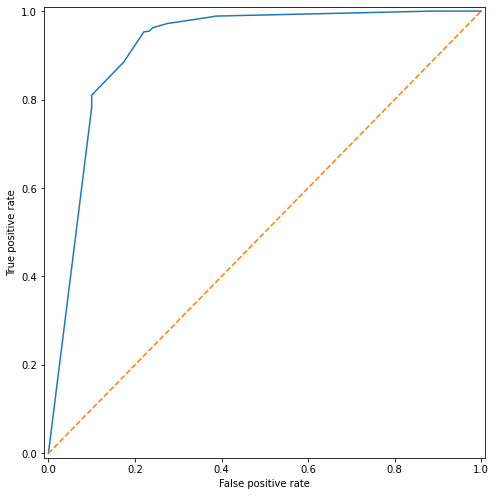

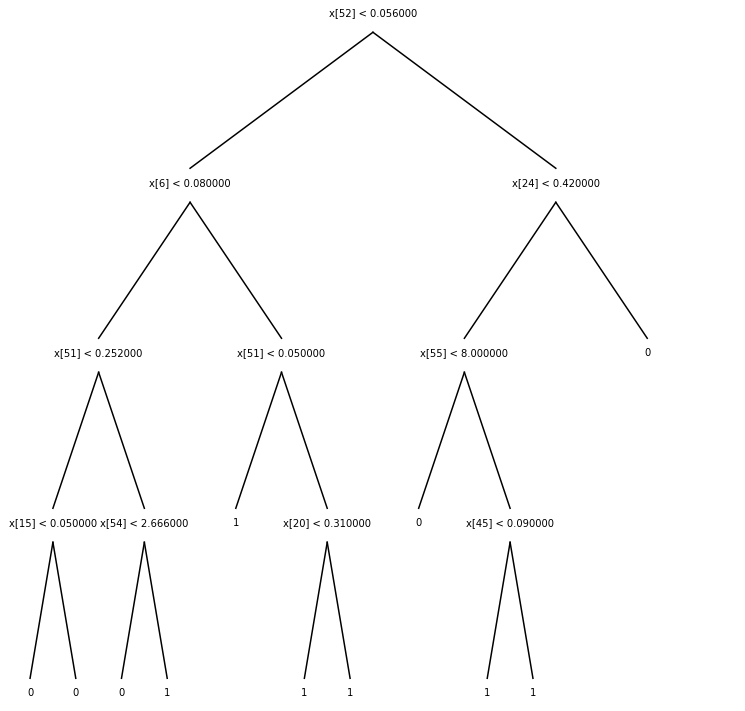

In [570]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
tree = DecisionTreeClassifier(max_depth=5, min_samples_leaf=30)
tree.fit(X_train, y_train)
plot_roc_curve(y_test, tree.predict_proba(X_test))
draw_tree(tree)
y_pred_tree = tree.predict(X_test)

kNN (проводим также скейлинг данных)

In [571]:
def standard_scaler(X):
    X_scaled = X.copy()
    X_scaled = (X_scaled - X_scaled.mean()) / X_scaled.std()
    return X_scaled

class KNearest:
    def __init__(self, n_neighbors=5, leaf_size=30):
        self.n_neighbors = n_neighbors
        self.leaf_size = leaf_size
        self.kdtree = None
        self.labels = None
        self.classes = None 
    
    def fit(self, X, y):
        self.kdtree = KDTree(X, leaf_size=self.leaf_size, metric='minkowski')
        self.labels = y.copy()
        self.classes = np.unique(y)
        
    def predict_proba(self, X):
        # Возвращает матрицу, в которой строки соответствуют элементам X, а столбцы - классам. На пересечении строки и столбца должна быть указана вероятность того, что элемент относится к классу
        # Вероятность рассчитывается как количество ближайших соседей с данным классом деленное на общее количество соседей
        dist, ind = self.kdtree.query(X, k=self.n_neighbors)
        
        result = []
        
        for i in ind:
            pred = self.labels[i]
            r = []
            for c in self.classes:
                r.append(sum(c == pred) / len(pred))
            result.append(r)
        
        return np.array(result)
        
    def predict(self, X):
        return self.classes[np.argmax(self.predict_proba(X), axis=1)]

knn = KNearest()

X_scaled = standard_scaler(np.concatenate([X_train, X_test]))

X_train_scaled = X_scaled[:X_train.shape[0]]
X_test_scaled = X_scaled[X_train.shape[0]:]

knn.fit(X_train_scaled, y_train)
y_pred_knn = knn.predict(X_test_scaled)

In [572]:
print('Tree:')
print('precision_score:', precision_score(y_test, y_pred_tree))
print('recall_score:', recall_score(y_test, y_pred_tree))
print('accuracy_score:', accuracy_score(y_test, y_pred_tree))

print('kNN:')
print('precision_score:', precision_score(y_test, y_pred_knn))
print('recall_score:', recall_score(y_test, y_pred_knn))
print('accuracy_score:', accuracy_score(y_test, y_pred_knn))

Tree:
precision_score: 0.9256965944272446
recall_score: 0.7666666666666667
accuracy_score: 0.8751357220412594
kNN:
precision_score: 0.7743732590529248
recall_score: 0.7128205128205128
accuracy_score: 0.7904451682953312


У дерева результаты лучше

Рак

In [583]:
cancer = pd.read_csv('hw2_data/cancer.csv')
X = cancer.drop(columns='label').to_numpy()
y = (cancer['label'].to_numpy() == 'M').astype(int)

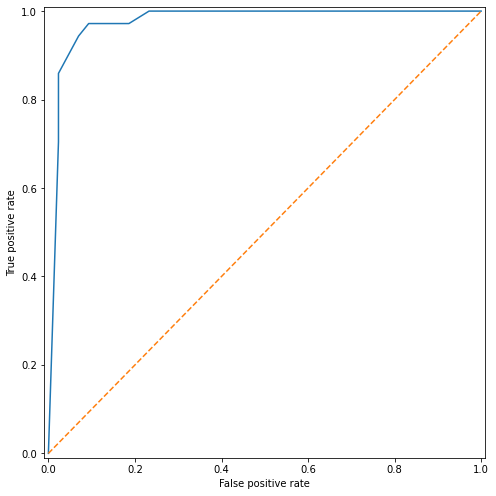

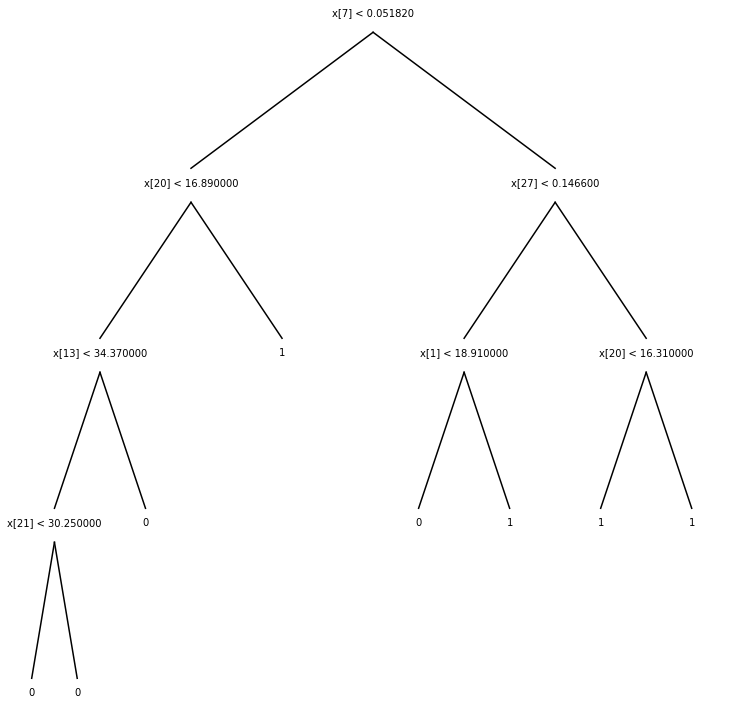

In [584]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
tree = DecisionTreeClassifier(max_depth=5, min_samples_leaf=15)
tree.fit(X_train, y_train)
plot_roc_curve(y_test, tree.predict_proba(X_test))
draw_tree(tree)
y_pred_tree = tree.predict(X_test)

In [585]:
knn = KNearest()

X_scaled = standard_scaler(np.concatenate([X_train, X_test]))

X_train_scaled = X_scaled[:X_train.shape[0]]
X_test_scaled = X_scaled[X_train.shape[0]:]

knn.fit(X_train_scaled, y_train)
y_pred_knn = knn.predict(X_test_scaled)

In [586]:
print('Tree:')
print('precision_score:', precision_score(y_test, y_pred_tree))
print('recall_score:', recall_score(y_test, y_pred_tree))
print('accuracy_score:', accuracy_score(y_test, y_pred_tree))

print('kNN:')
print('precision_score:', precision_score(y_test, y_pred_knn))
print('recall_score:', recall_score(y_test, y_pred_knn))
print('accuracy_score:', accuracy_score(y_test, y_pred_knn))

Tree:
precision_score: 0.9512195121951219
recall_score: 0.9069767441860465
accuracy_score: 0.9473684210526315
kNN:
precision_score: 1.0
recall_score: 0.8837209302325582
accuracy_score: 0.956140350877193


Результаты очень близки, по метрике реколл у дерева результат лучше